In [1]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

Загрузим файл HR.csv с данными по опросу уровня удовлетворенности сотрудниками работой.

Данные имеют следующие признаки:

1. satisfaction_level - уровень удовлетворенности работой
1. last_evaluation - время с момента последней оценки в годах
1. number_project - количество проектов, выполненных за время работы
1. average_monthly_hours - среднее количество часов на рабочем месте в месяц
1. time_spend_company - стаж работы в компании в годах
1. Work_accident - происходили ли несчастные случаи на рабочем месте с сотрудником
1. left - уволился ли сотрудник
1. promotion_last_5years - повышался ли сотрудник за последние пять лет
1. department - отдел в котором работает сотрудник
1. salary - относительный уровень зарплаты

In [2]:
df_hr = pd.read_csv('HR.csv')
df_hr[:10]

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low


Проверим есть ли в датафрейме незаполненные ячейки

In [3]:
len(df_hr) - df_hr.count()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

Незаполненные поля отсутствуют в датафрейме. Работа по заполнению пропущенных значений не требуется.

Заменим уровень зарплат low, medium, high на 1, 2, 3 соответственно.

In [4]:
df_hr.salary = df_hr.salary.apply(lambda value: 1 if value == 'low' else 2 if value == 'medium' else 3)
df_hr[:10]

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,1
1,0.80,0.86,5,262,6,0,1,0,sales,2
2,0.11,0.88,7,272,4,0,1,0,sales,2
3,0.72,0.87,5,223,5,0,1,0,sales,1
4,0.37,0.52,2,159,3,0,1,0,sales,1
5,0.41,0.50,2,153,3,0,1,0,sales,1
6,0.10,0.77,6,247,4,0,1,0,sales,1
7,0.92,0.85,5,259,5,0,1,0,sales,1
8,0.89,1.00,5,224,5,0,1,0,sales,1
9,0.42,0.53,2,142,3,0,1,0,sales,1


Рассчитаем основные статистики для всех переменных (среднее,медиана,мода,мин/макс,сред.отклонение)

In [5]:
def make_df_init_stats(dataframe):
    """ Функция для расчета базовой статистики датафрейма pandas
    
    Входные параметры:
        dataframe -- датафрейм pandas
        
    Результат: датафрейм pandas с базовой статистикой
    """
    
    if not isinstance(dataframe, pd.core.frame.DataFrame):
        raise TypeError('В переменной dataframe должен находиться объект pd.core.frame.DataFrame')
    
    # Строим датафрейм с базовой статистикой
    df_init_stat = dataframe.describe()
    
    # Добавляем моду в фрейм базовой статистики
    # Берем среднее значение, так как в столбце average_montly_hours у нас 2 моды.
    # В других столбцах мода одна, поэтому среднее значение будет равной настоящей моде
    df_init_stat.loc['mode', :] = dataframe.mode().mean()
    
    # Для моды уровней удовлетворенности и времени оценки в годах округлим значения до десятых
    df_init_stat.loc['mode', 'satisfaction_level'] = dataframe.satisfaction_level.round(1).mode().mean()
    df_init_stat.loc['mode', 'last_evaluation'] = dataframe.last_evaluation.round(1).mode().mean()
    
    # Для моды времени на рабочем месте сделаем округление до целых частей часов
    df_init_stat.loc['mode', 'average_montly_hours'] = dataframe.average_montly_hours.round().mode().mean()
    
    return df_init_stat

In [6]:
display(make_df_init_stats(df_hr))

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268,1.594706
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281,0.637183
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,1.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,1.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,2.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000,2.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000,3.000000
mode,0.800000,0.600000,4.000000,145.500000,3.000000,0.000000,0.000000,0.000000,1.000000


Анализ базовых статистик

- Если предположить, что соотрудники с satisfaction_level более 0.75 удовлетворены работой, то более половины сотружников компании работой неудовлетворены. Об этом же говорит среднее значение 0.61. Наибольшая группа людей в компании - сотрудники с уровнем удовлетворенности от 0.80 до 0.89 включительно по сравнению с девятью группами из других диапазонов.

- Во всех столбцах среднее значение практически совпадает с медианным, значит у нас нет значительных выбросов в данных.

- Все сотрудники компании проходили оценку не более 1 года назад.

- Если взять среднемесячное количество рабочих часов при 8 часовом графике в 2020 году как [164.17](https://clubtk.ru/srednee-kolichestvo-rabochikh-dney-v-mesyatse), то по average_monthly_hours можно сказать, что более половины сотрудников перерабатывают рабочее время.

- В компании работают опытные сотрудники с минимальным стажем работы в компании от 2 лет. Средний стаж в компании - 3.5 лет. Со стажем в 10 лет работает 214 сотрудников из 14999. Со стажем от 6 лет и выше 1282 сотрудника из 14999.

- Более с 75% сотрудниками не происходили несчастные случаи. несчастные случаи произошли с 2169 из 14999 сотрудниками.

- Более 75% сотрудников остались в компании. Уволились 3571 из 14999 сотрудников.

- Более 75% сотрудников не повышались более 5 лет. Были повышены только 319 из 14999 сотрудников. Получается, что оценивают людей ежегодно, но повышают в течение 5 лет крайне малое количество людей. Это может вызывать напряжение и недовольство в коллективе.

- Не менее 25% сотрудников имеют низкий уровень зарплаты. При этом нихкий уровень зарплаты имеет модальное значение, значит эта группа сотрудников самая большая, по сравнению с двумя другими. Предположительно этот фактор может вызывать негатив в компании.

Рассчитаем корреляционные матрицы для наших данных. Так как у нас смешанные данные (категориальные и количественные), то разумнее всего расчитать матрицу с помощью коэффициента корреляции Кендалла, который позволяет сравнивать между собой количественные и категориальные данные и не привязан к линейной зависимости и нормальному распределению.

Также построим точечные графики для всех признаков между собой.

In [7]:
df_hr_corr_matrix = df_hr.corr(method='kendall')
df_hr_corr_matrix

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary
satisfaction_level,1.000000,0.113865,0.022077,0.051126,-0.110005,0.046298,-0.300675,0.018332,0.036069
last_evaluation,0.113865,1.000000,0.266267,0.235374,0.118842,-0.004749,-0.002010,-0.005903,-0.007294
number_project,0.022077,0.266267,1.000000,0.306987,0.195025,0.002096,-0.017601,-0.002666,0.003855
average_montly_hours,0.051126,0.235374,0.306987,1.000000,0.119466,-0.004966,0.038045,-0.002417,0.001896
time_spend_company,-0.110005,0.118842,0.195025,0.119466,1.000000,-0.024839,0.244851,0.032059,0.001250
Work_accident,0.046298,-0.004749,0.002096,-0.004966,-0.024839,1.000000,-0.154622,0.039245,0.008234
left,-0.300675,-0.002010,-0.017601,0.038045,0.244851,-0.154622,1.000000,-0.061788,-0.147580
promotion_last_5years,0.018332,-0.005903,-0.002666,-0.002417,0.032059,0.039245,-0.061788,1.000000,0.091372
salary,0.036069,-0.007294,0.003855,0.001896,0.001250,0.008234,-0.147580,0.091372,1.000000


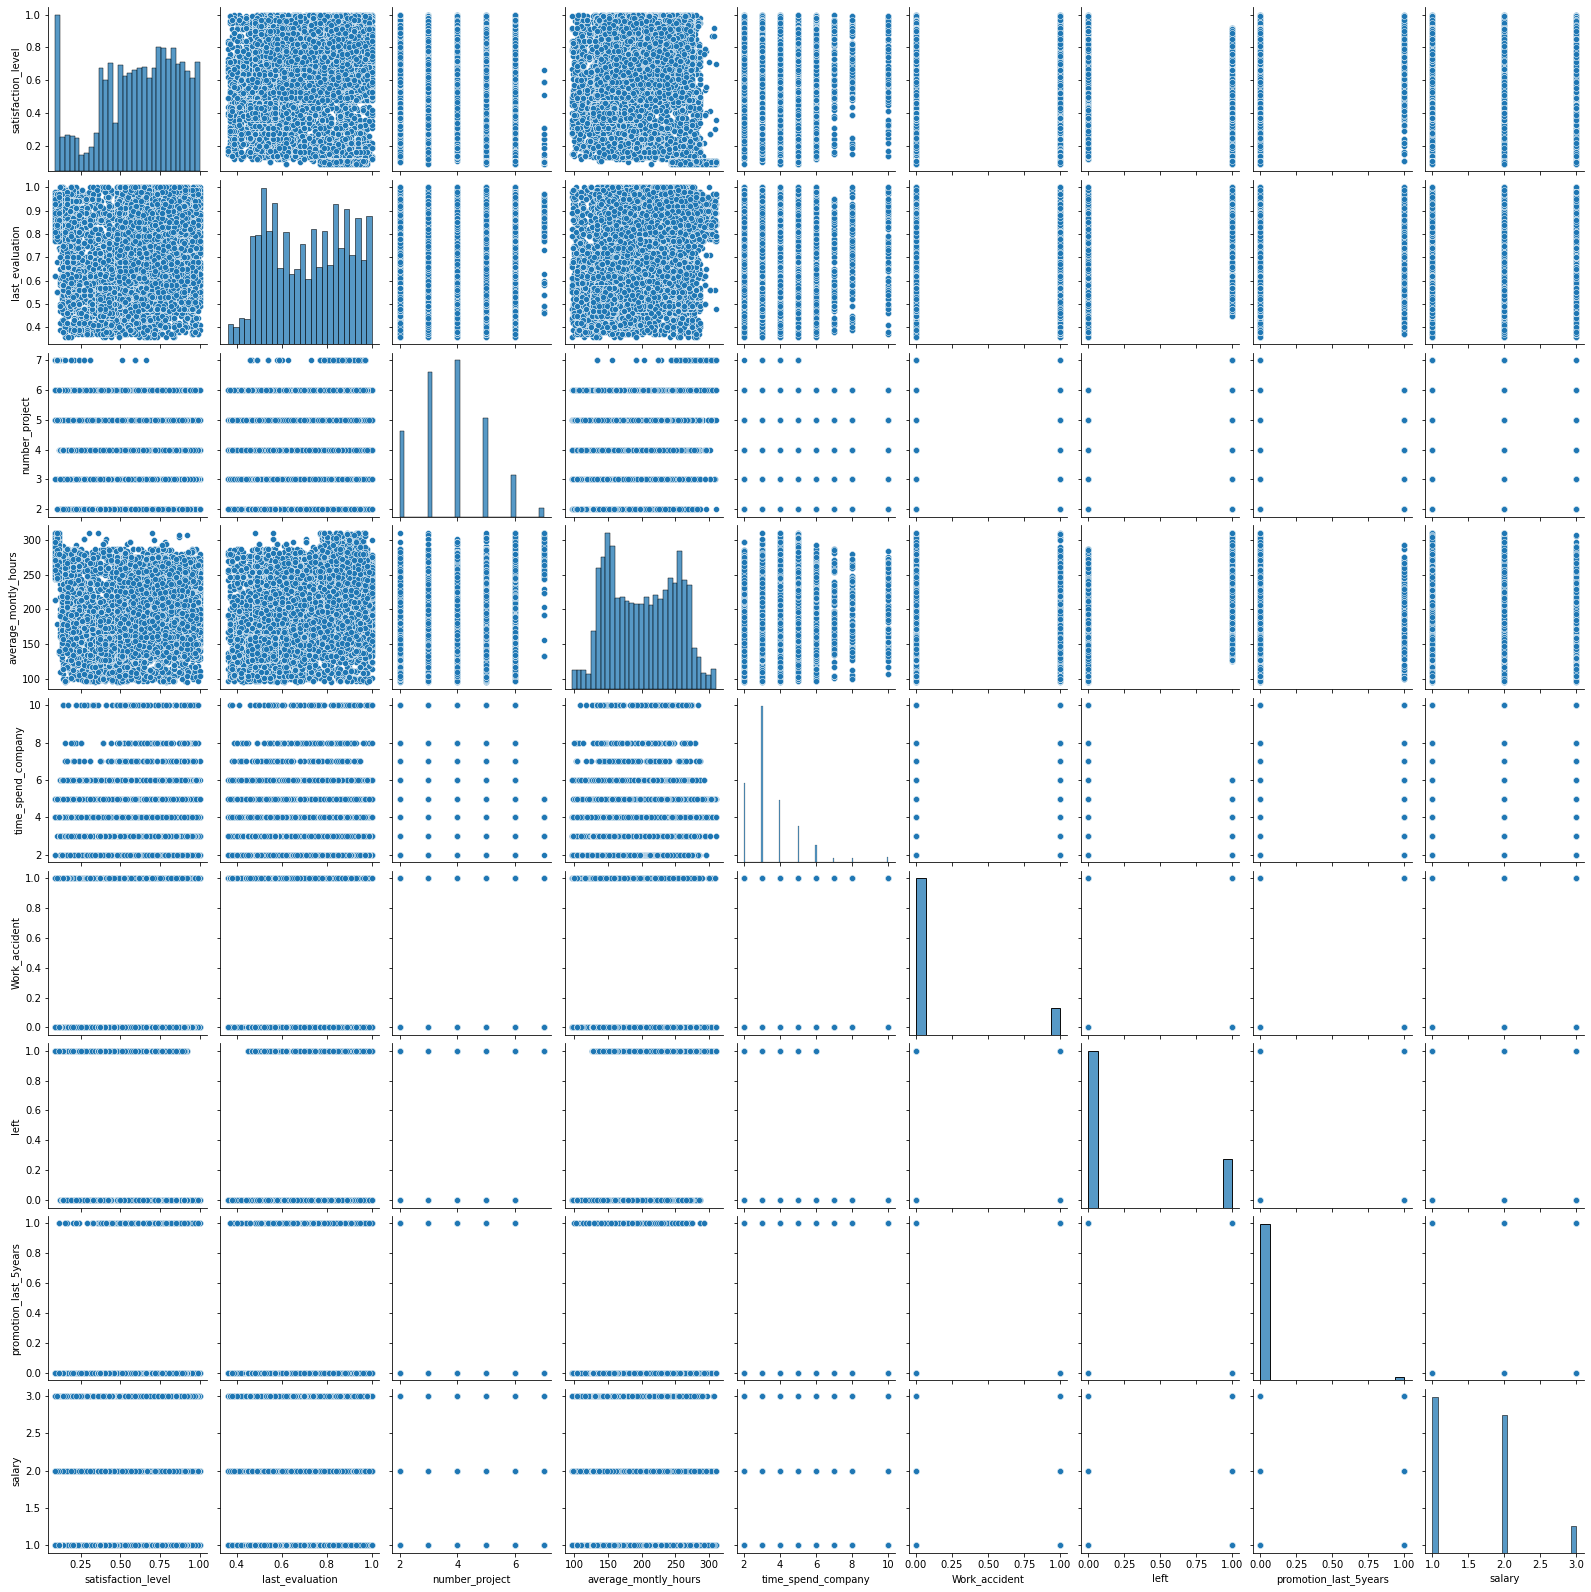

In [8]:
sns.pairplot(df_hr)

In [9]:
# находим максимальные абсолютные значения в каждом столбце, сортируем столбцы по убыванию и берем 2 первых
# При этом значение 1 заменяем на 0, так как 1 - корреляция признаков самих с собой
sr_corr_max = df_hr_corr_matrix.replace({1:0}).abs().max().sort_values(ascending=False).iloc[:1]

print("Два максимально скоррелированных между собой признака")

# Получаем названия столбцов с максимальными значениями и их переменные
cat = sr_corr_max.index[0]
val = sr_corr_max.values[0]

# С помощью найденных названий столбцов и переменных находим Series с максимальной корреляцией
display(df_hr_corr_matrix.loc[df_hr_corr_matrix.abs()[cat] == val, cat])

Два максимально скоррелированных между собой признака


number_project    0.306987
Name: average_montly_hours, dtype: float64

In [10]:
# Находим минимальные абсолютные значения в каждом столбце, сортируем столбцы возрастанию и берем одну
sr_corr_min = df_hr_corr_matrix.abs().min().sort_values(ascending=True).iloc[:1]

print("Два минимально скоррелированных между собой признака")

# Получаем названия столбцов с с минимальными значениями и их переменные
val = sr_corr_min.values[0]
cat = sr_corr_min.index[0]

# С помощью найденных названий столбцов и переменных находим Series с минимальной корреляцией
display(df_hr_corr_matrix.loc[df_hr_corr_matrix.abs()[cat] == val, cat])

Два минимально скоррелированных между собой признака


salary    0.00125
Name: time_spend_company, dtype: float64

Как видно из расчета две самые скоррелированные переменные - number_project и average_montly_hours. А минимально скорелированные - salary и time_spend_company. 

При этом можно утверждать, что во всех признаках корреляция либо отсутствует, либо минимальная. 

Рассчитаем количество сотрудников в каждом департаменте.

In [11]:
df_hr[['department', 'salary']].groupby(by='department').count().rename({'salary': 'employees'}, axis=1)

,employees
department,
IT,1227
RandD,787
accounting,767
hr,739
management,630
marketing,858
product_mng,902
sales,4140
support,2229


Посмотрим на распределение зарплат всех сотрудников компании.

Text(0, 0.5, 'Частотность уровня')

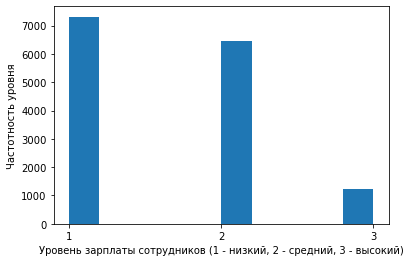

In [12]:
df_hr['salary'].plot(kind='hist')
plt.xticks([1,2,3])
plt.xlabel("Уровень зарплаты сотрудников (1 - низкий, 2 - средний, 3 - высокий)")
plt.ylabel("Частотность уровня")

Из графика видно, что практически половина сотрудников имеет низкий уровень дохода.

Посмотрим на распределение зарплат сотрудников по каждому департаменту в отдельности.

In [13]:
# Построим сводну таблицу для значений
df_pivot_dep_salary = df_hr.pivot_table(values='satisfaction_level', index='department', aggfunc='count', 
                                        columns='salary', fill_value=0).rename({1: 'low', 2: 'mid', 3: 'high'}, axis=1)
df_pivot_dep_salary

salary,low,mid,high
department,,,
IT,609,535,83
RandD,364,372,51
accounting,358,335,74
hr,335,359,45
management,180,225,225
marketing,402,376,80
product_mng,451,383,68
sales,2099,1772,269
support,1146,942,141


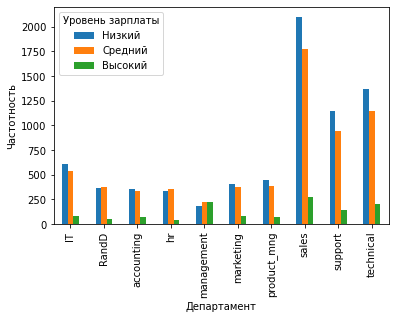

In [14]:
df_pivot_dep_salary.plot(kind='bar')
plt.xlabel("Департамент")
plt.ylabel("Частотность")
plt.legend(['Низкий', 'Средний', 'Высокий'], title='Уровень зарплаты')
plt.show()

Проверим гипотезу, что сотрудники с высоким окладом проводят на работе больше времени, чем сотрудники с низким окладом.

Сформируем массивы данных для сотрудников с низкой зарплатой и высокой.

In [15]:
df_time_spend_low_salary = df_hr[df_hr.salary == 1][['average_montly_hours']]
df_time_spend_high_salary = df_hr[df_hr.salary == 3][['average_montly_hours']]

Проверим имеют ли наши данные нормальное распределение с помощью визуализации.

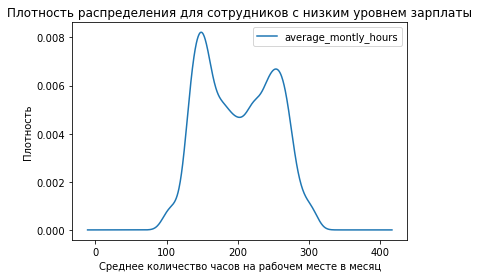

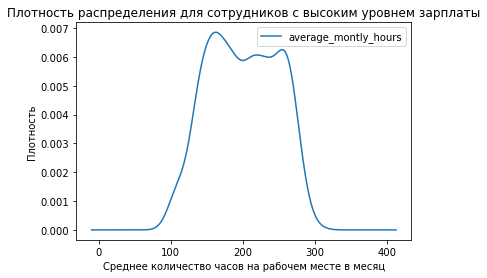

In [16]:
df_time_spend_low_salary.plot(kind='density')
plt.title('Плотность распределения для сотрудников с низким уровнем зарплаты')
plt.xlabel('Среднее количество часов на рабочем месте в месяц')
plt.ylabel('Плотность')
plt.show()

df_time_spend_high_salary.plot(kind='density')
plt.title('Плотность распределения для сотрудников с высоким уровнем зарплаты')
plt.xlabel('Среднее количество часов на рабочем месте в месяц')
plt.ylabel('Плотность')
plt.show()

Как видно из графиков имеем не совсем типичное для нормального распределения данные, поэтому для проверки гипотез нам больше всего подойдет U-критерий Манна-Уитни для несвязанных выборок.

**Сформируем гипотезы:**

H0 - Сотрудники с высоким окладом проводят на работе столько же времени, как и соотрудники с низким, либо меньше  
H1 - Сотрудники с высоким окладом проводят на работе больше времени, чем с низким

В данном случае у нас тест односторонний, при этом интересуют различия в верхней части плотности распределения значений.

In [17]:
alpha = 0.05

time_spend_high_salary_mean = df_time_spend_high_salary.mean()
time_spend_low_salary_mean = df_time_spend_low_salary.mean()

_, p = scipy.stats.mannwhitneyu(df_time_spend_high_salary.average_montly_hours,
                                df_time_spend_low_salary.average_montly_hours,
                                alternative='greater')

print('p-value:', p)

if p < alpha and time_spend_high_salary_mean > time_spend_low_salary_mean:
    print('Сотрудники с высоким окладом проводят на работе больше времени, чем с низким')
else:
    print('Сотрудники с высоким окладом проводят на работе столько же времени, как и соотрудники с низким, либо меньше')

p-value: 0.5879383099013082
Сотрудники с высоким окладом проводят на работе столько же времени, как и соотрудники с низким, либо меньше


Рассчитаем следующие показатели среди уволившихся и неуволившихся сотрудников (по отдельности):

- Доля сотрудников с повышением за последние 5 лет (процент)
- Средняя степень удовлетворенности
- Среднее количество проектов

In [18]:
df_stat = df_hr[['left', 'satisfaction_level', 'number_project']].groupby('left').mean()
df_stat['promotion_last_5years'] = (df_hr[['left', 'promotion_last_5years']]
                                    .groupby('left').apply(lambda df: len(df[df.promotion_last_5years==1])/len(df)*100))
df_stat.rename({'satisfaction_level': 'satisfaction_level_mean', 
                'number_project': 'number_project_mean', 
                'promotion_last_5years': 'promotion_last_5years_percent'}, axis=1, inplace=True)
df_stat

,satisfaction_level_mean,number_project_mean,promotion_last_5years_percent
left,,,
0,0.666810,3.786664,2.625131
1,0.440098,3.855503,0.532064


Построим модель LDA, предсказывающую уволился ли сотрудник на основе имеющихся факторов (кроме department и salary)

In [19]:
# Разделиv данные на тестовую и обучающую выборки.  
X_train, X_test, y_train, y_test = train_test_split(df_hr[['satisfaction_level', 'last_evaluation', 
                                                              'number_project', 'average_montly_hours', 
                                                              'time_spend_company', 'Work_accident', 
                                                              'promotion_last_5years']],
                                                   df_hr['left'],
                                                   test_size=0.3,
                                                   random_state=42)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_predict = lda.predict(X_test)
print("Точность модели:", accuracy_score(y_predict, y_test))

Точность модели: 0.7557777777777778


Попробуем включить salary в нашу модель и посмотрим как изменится ее точность.

In [20]:
# Разделиv данные на тестовую и обучающую выборки.  
X_train, X_test, y_train, y_test = train_test_split(df_hr[['satisfaction_level', 'last_evaluation', 
                                                              'number_project', 'average_montly_hours', 
                                                              'time_spend_company', 'Work_accident', 
                                                              'promotion_last_5years', 'salary']],
                                                   df_hr['left'],
                                                   test_size=0.3,
                                                   random_state=42)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_predict = lda.predict(X_test)
print("Точность модели:", accuracy_score(y_predict, y_test))

Точность модели: 0.77


В первом случае получили точность 0.756, во втором 0.77. Проанализируем матрицу ошибок.

In [21]:
confusion_matrix(y_test, y_predict)

array([[3152,  276],
       [ 759,  313]], dtype=int64)

По матрице ошибок можно сделать следующие выводы:

1. В 759 случаев мы верно определили, что человек собирается уволиться.
2. В 313 случаях мы ошиблись с предсказанием увольнения, люди на самом деле не уволились. В связи с этим есть риски оказать давление на человека и поспешить с его увольнением.
3. В 3152 случаев мы верно предсказали отсутствие желание у человека к увольнению
4. В 276 случаях мы ошибочно предсказали отсутсвие желания у людей к увольнению, на самом деле они уволились. Здесь есть риск возложить излишние надежды на человека и ответственную работу, которую он может неожиданно бросить и уйти из компании.